In [104]:
import numpy as np                   
import pandas as pd                 
import xgboost as xgb                
import shap

import matplotlib.pyplot as plt
pd.options.display.max_columns = 999

%matplotlib inline

np.random.seed(12345)

# Explore and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 24 variables. We will use the following as inputs to our multinomial model: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_2` - `PAY_6`**: History of past payment; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT2` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 21 input variables are used to predict the target variable, the payment status in Sept 2005 (`PAY_0`). Because XGBoost accepts only numeric inputs, all variables will be treated as numeric.

### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data.

In [105]:
#Import XLS file
path = './data/default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

### Assign modeling roles

The shorthand name `y` is assigned to the prediction target, `PAY_0`. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`, the typical outcome for a binary case, `default payment next month`, and `PAY_AMT1`, which is a variable that contains payment information about Sept, 2005 which we would normally NOT know given the outcome, `PAY_0` (payment status in Sept 2005).

In [106]:
#Assign target and inputs for GBM
y = 'PAY_0'
X = [name for name in data.columns if name not in [y, 'ID','default payment next month', 'PAY_AMT1']]
print('y =', y)
print('X =', X)

y = PAY_0
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [107]:
#Convert PAY_0 to be 0-num_classes as XGBoost expects a multinomial outcome to have a min value of 0
for i in range(0, data.shape[0]):
    if data["PAY_0"][i] < 0:
        data["PAY_0"][i] = 0

#PAY_0 summary:
#0:'no consumption', 'pay duly', 'use of revolving credit', 
#1:'1 month delay', 
#2:'2 month delay', 
#3:'3 month delay', 
#4:'4 month delay', 
#5:'5 month delay', 
#6:'6 month delay', 
#7:'7 month delay', 
#8:'8 month delay'

### Display descriptive statistics
The Pandas `describe()` function displays a brief description of the credit card default data. The input variables `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_2`-`PAY_6`, and the prediction target `PAY_0`, are really categorical variables, but they have already been encoded into meaningful numeric, integer values, which is great for XGBoost. Also, there are no missing values in this dataset.

In [108]:
data[X + [y]].describe() #Display descriptive statistics for all columns

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_0
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.356767
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.760594
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,8.000000


# Train multinomial XGBoost model

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable. XGBoost's early stopping functionality is also used to limit overfitting to the training data

XGBoost is available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

After training, global Shapley variable importance is calculated and displayed. To enhance trust in the GBM model, variable importance values should typically conform to human domain knowledge and reasonable expectations.

### Split data into training and test sets for early stopping

The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [109]:
np.random.seed(12345) #Set random seed for reproducibility
split_ratio = 0.7     #70%/30% train/test split

#Execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

#Summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


### Train XGBoost GBM multinomial classifier
To train an XGBoost multinomial classifier, the training and test data must be converted from Pandas DataFrames into SVMLight format. The `DMatrix()` function in the XGBoost package is used to convert the data. 

Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` paramter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test multiclass logloss fails to decrease for 50 iterations.

In [110]:
dtrain = xgb.DMatrix(train[X], label=train[y])
dtest = xgb.DMatrix(test[X], label=test[y])

#Tuning parameters
params = {
    'objective': 'multi:softprob',              #Multinomial classification
    'booster': 'gbtree',                        #Base learner will be decision tree
    'eval_metric': 'mlogloss',                  #Stop training based on multinomial logloss
    'eta': 0.01,                                #Learning rate
    #'subsample': 0.9,                           #Use 90% of rows in each decision tree
    #'colsample_bytree': 0.9,                    #Use 90% of columns in each decision tree
    'max_depth': 6,                             #Allow decision trees to grow to depth of 6
    'seed': 12345,                              #Set random seed for reproducibility
    'num_class': 9
}

#Watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

#Train model
xgb_model = xgb.train(params,                   #Set tuning parameters from above                   
                      dtrain,                   #Training data
                      1000,                     #Maximum of 1000 iterations (trees)
                      evals=watchlist,          #Use watchlist for early stopping 
                      early_stopping_rounds=50, #Stop after 50 iterations (trees) without decrease in mlogloss
                      verbose_eval=True)        #Display iteration progress


[16:13:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[16:13:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[16:13:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[16:13:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:13:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[16:13:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[16:13:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:13:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_dep

[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_dep

[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_dep

[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_dep

[31]	train-mlogloss:1.4593	eval-mlogloss:1.46723
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:45] src/tree/updater_prune.cc:74: tree pruning end

[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[39]	train-mlogloss:1.34687	eval-mlogloss:1.35634
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:46] src/tree/updater_prune.cc:74: tree pruning en

[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_dep

[55]	train-mlogloss:1.16369	eval-mlogloss:1.17587
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:47] src/tree/updater_prune.cc:74: tree pruning en

[63]	train-mlogloss:1.08778	eval-mlogloss:1.10116
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:47] src/tree/updater_prune.cc:74: tree pruning e

[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[71]	train-mlogloss:1.02003	eval-mlogloss:1.03456
[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[16:13:48] src/tree/updater_prune.cc:74: tree pruning e

[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[79]	train-mlogloss:0.959226	eval-mlogloss:0.974815
[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:49] src/tree/updater_prune.cc:74: tree pruning

[16:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[87]	train-mlogloss:0.904437	eval-mlogloss:0.921017
[16:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:13:49] src/tree/updater_prune.cc:74: tree pruning 

[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[95]	train-mlogloss:0.854882	eval-mlogloss:0.872427
[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:13:50] src/tree/updater_prune.cc:74: tree pruning 

[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[103]	train-mlogloss:0.809868	eval-mlogloss:0.828395
[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:13:50] src/tree/updater_prune.cc:74: tree pruning

[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[111]	train-mlogloss:0.768873	eval-mlogloss:0.788464
[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:13:51] src/tree/updater_prune.cc:74: tree pruning

[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[119]	train-mlogloss:0.731459	eval-mlogloss:0.752091
[16:13:51] src/tree/updater_prune.cc:74: tree pruning 

[126]	train-mlogloss:0.701284	eval-mlogloss:0.722849
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:52] src/tree/updater_prune.cc:74: tree pruni

[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[134]	train-mlogloss:0.669544	eval-mlogloss:0.69215
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:13:52] src/tree/updater_prune.cc:74: tree pruning

[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_d

[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_de

[158]	train-mlogloss:0.589159	eval-mlogloss:0.614804
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:54] src/tree/updater_prune.cc:74: tree prun

[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_d

[16:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[174]	train-mlogloss:0.545614	eval-mlogloss:0.573198
[16:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:13:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[16:13:55] src/tree/updater_prune.cc:74: tree pruni

[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[182]	train-mlogloss:0.526368	eval-mlogloss:0.554914
[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:13:56] src/tree/updater_prune.cc:74: tree pruning

[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[190]	train-mlogloss:0.508644	eval-mlogloss:0.538028
[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[16:13:56] src/tree/updater_prune.cc:74: tree pruni

[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[198]	train-mlogloss:0.4923	eval-mlogloss:0.522479
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:13:57] src/tree/updater_prune.cc:74: tree pruning 

[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[206]	train-mlogloss:0.477206	eval-mlogloss:0.508163
[16:13:57] src/tree/updater_prune.cc:74: tree pruning 

[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[213]	train-mlogloss:0.464943	eval-mlogloss:0.496569
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:58] src/tree/updater_prune.cc:74: tree pruni

[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_d

[16:13:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[229]	train-mlogloss:0.439539	eval-mlogloss:0.472957
[16:13:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[16:13:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16:13:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:13:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:13:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:13:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:13:59] src/tree/updater_prune.cc:74: tree prunin

[16:13:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:13:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:13:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[237]	train-mlogloss:0.428114	eval-mlogloss:0.462514
[16:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[16:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:00] src/tree/updater_prune.cc:74: tree pruning

[16:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[16:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[245]	train-mlogloss:0.417491	eval-mlogloss:0.45286
[16:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[16:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:14:00] src/tree/updater_prune.cc:74: tree pruning 

[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[253]	train-mlogloss:0.407582	eval-mlogloss:0.443909
[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:14:01] src/tree/updater_prune.cc:74: tree prunin

[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[261]	train-mlogloss:0.398355	eval-mlogloss:0.435653
[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:14:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[16:14:01] src/tree/updater_prune.cc:74: tree prunin

[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[269]	train-mlogloss:0.389864	eval-mlogloss:0.427986
[16:14:02] src/tree/updater_prune.cc:74: tree pruning 

[276]	train-mlogloss:0.382887	eval-mlogloss:0.421779
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:02] src/tree/updater_prune.cc:74: tree prunin

[284]	train-mlogloss:0.37545	eval-mlogloss:0.415174
[16:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[16:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[16:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:03] src/tree/updater_prune.cc:74: tree pruning

[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[292]	train-mlogloss:0.368532	eval-mlogloss:0.409043
[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:04] src/tree/updater_prune.cc:74: tree prunin

[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[300]	train-mlogloss:0.362149	eval-mlogloss:0.403329
[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:04] src/tree/updater_prune.cc:74: tree prunin

[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[308]	train-mlogloss:0.356135	eval-mlogloss:0.398035
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:14:05] src/tree/updater_prune.cc:74: tree pruning

[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[316]	train-mlogloss:0.350412	eval-mlogloss:0.39313
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:14:05] src/tree/updater_prune.cc:74: tree pruning 

[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[324]	train-mlogloss:0.344977	eval-mlogloss:0.38857
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:14:06] src/tree/updater_prune.cc:74: tree pruning 

[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_de

[339]	train-mlogloss:0.335878	eval-mlogloss:0.380796
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:07] src/tree/updater_prune.cc:74: tree prunin

[347]	train-mlogloss:0.33145	eval-mlogloss:0.377047
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:08] src/tree/updater_prune.cc:74: tree pruning

[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[355]	train-mlogloss:0.327292	eval-mlogloss:0.37357
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:08] src/tree/updater_prune.cc:74: tree pruning

[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[363]	train-mlogloss:0.323372	eval-mlogloss:0.37032
[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:09] src/tree/updater_prune.cc:74: tree pruning 

[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[371]	train-mlogloss:0.31962	eval-mlogloss:0.367353
[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:09] src/tree/updater_prune.cc:74: tree pruning 

[16:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[379]	train-mlogloss:0.316048	eval-mlogloss:0.364645
[16:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[16:14:10] src/tree/updater_prune.cc:74: tree pruning

[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[387]	train-mlogloss:0.312623	eval-mlogloss:0.362108
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[16:14:11] src/tree/updater_prune.cc:74: tree pruning

[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_de

[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_de

[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_de

[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[418]	train-mlogloss:0.301218	eval-mlogloss:0.35347
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:13] src/tree/updater_prune.cc:74: tree pruning

[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_de

[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_de

[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_de

[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_de

[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_de

[466]	train-mlogloss:0.286813	eval-mlogloss:0.343347
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:16] src/tree/updater_prune.cc:74: tree prunin

[474]	train-mlogloss:0.284718	eval-mlogloss:0.341965
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:17] src/tree/updater_prune.cc:74: tree prunin

[482]	train-mlogloss:0.282578	eval-mlogloss:0.340694
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:17] src/tree/updater_prune.cc:74: tree prunin

[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[490]	train-mlogloss:0.280504	eval-mlogloss:0.339483
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:14:18] src/tree/updater_prune.cc:74: tree pruning

[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[498]	train-mlogloss:0.278633	eval-mlogloss:0.338358
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:18] src/tree/updater_prune.cc:74: tree pruning

[16:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[506]	train-mlogloss:0.276867	eval-mlogloss:0.337279
[16:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:19] src/tree/updater_prune.cc:74: tree pruning 

[514]	train-mlogloss:0.27513	eval-mlogloss:0.336218
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:20] src/tree/updater_prune.cc:74: tree pruning 

[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_dep

[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_dep

[538]	train-mlogloss:0.270018	eval-mlogloss:0.333426
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:21] src/tree/updater_prune.cc:74: tree pruning

[546]	train-mlogloss:0.268444	eval-mlogloss:0.332572
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:22] src/tree/updater_prune.cc:74: tree prunin

[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[554]	train-mlogloss:0.26689	eval-mlogloss:0.331795
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:22] src/tree/updater_prune.cc:74: tree pruning 

[16:14:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[562]	train-mlogloss:0.265417	eval-mlogloss:0.331098
[16:14:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:14:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:14:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[16:14:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:23] src/tree/updater_prune.cc:74: tree pruning 

[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[570]	train-mlogloss:0.263966	eval-mlogloss:0.33042
[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:24] src/tree/updater_prune.cc:74: tree pruning e

[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[578]	train-mlogloss:0.262612	eval-mlogloss:0.329809
[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:14:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:24] src/tree/updater_prune.cc:74: tree pruning 

[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[586]	train-mlogloss:0.261312	eval-mlogloss:0.329221
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:14:25] src/tree/updater_prune.cc:74: tree pruning 

[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_de

[601]	train-mlogloss:0.258873	eval-mlogloss:0.328131
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:26] src/tree/updater_prune.cc:74: tree pruning

[609]	train-mlogloss:0.257577	eval-mlogloss:0.327592
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:26] src/tree/updater_prune.cc:74: tree pruning

[16:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[16:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[16:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[16:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_dep

[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[625]	train-mlogloss:0.255011	eval-mlogloss:0.326614
[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:28] src/tree/updater_prune.cc:74: tree pruning

[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[633]	train-mlogloss:0.253801	eval-mlogloss:0.326135
[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:28] src/tree/updater_prune.cc:74: tree pruning 

[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[641]	train-mlogloss:0.252622	eval-mlogloss:0.325678
[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:29] src/tree/updater_prune.cc:74: tree pruning

[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[649]	train-mlogloss:0.251457	eval-mlogloss:0.32529
[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[16:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:29] src/tree/updater_prune.cc:74: tree pruning e

[16:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[16:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[16:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[657]	train-mlogloss:0.25029	eval-mlogloss:0.324882
[16:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[16:14:30] src/tree/updater_prune.cc:74: tree pruning 

[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_dep

[672]	train-mlogloss:0.248312	eval-mlogloss:0.324168
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:31] src/tree/updater_prune.cc:74: tree prunin

[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[680]	train-mlogloss:0.247292	eval-mlogloss:0.323803
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:32] src/tree/updater_prune.cc:74: tree pruning

[688]	train-mlogloss:0.24634	eval-mlogloss:0.323458
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:32] src/tree/updater_prune.cc:74: tree pruning 

[16:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[696]	train-mlogloss:0.245424	eval-mlogloss:0.323156
[16:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[16:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:33] src/tree/updater_prune.cc:74: tree pruning

[16:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[704]	train-mlogloss:0.244551	eval-mlogloss:0.322864
[16:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[16:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[16:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:34] src/tree/updater_prune.cc:74: tree pruning 

[16:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[712]	train-mlogloss:0.243736	eval-mlogloss:0.322545
[16:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[16:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[16:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:34] src/tree/updater_prune.cc:74: tree pruning

[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[720]	train-mlogloss:0.242848	eval-mlogloss:0.322259
[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:35] src/tree/updater_prune.cc:74: tree pruning

[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[728]	train-mlogloss:0.242033	eval-mlogloss:0.321984
[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[16:14:35] src/tree/updater_prune.cc:74: tree pruning 

[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[736]	train-mlogloss:0.241245	eval-mlogloss:0.321712
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[16:14:36] src/tree/updater_prune.cc:74: tree pruning

[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_dep

[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_dep

[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[759]	train-mlogloss:0.238918	eval-mlogloss:0.320968
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:37] src/tree/updater_prune.cc:74: tree pruning

[16:14:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[767]	train-mlogloss:0.238295	eval-mlogloss:0.320763
[16:14:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[16:14:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[16:14:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[16:14:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[16:14:38] src/tree/updater_prune.cc:74: tree pruning

[775]	train-mlogloss:0.237604	eval-mlogloss:0.320577
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:39] src/tree/updater_prune.cc:74: tree pruning

[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_dep

[791]	train-mlogloss:0.236293	eval-mlogloss:0.320222
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:40] src/tree/updater_prune.cc:74: tree pruning

[799]	train-mlogloss:0.235648	eval-mlogloss:0.320058
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:14:40] src/tree/updater_prune.cc:74: tree pruning

[16:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[807]	train-mlogloss:0.235016	eval-mlogloss:0.319928
[16:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[16:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:41] src/tree/updater_prune.cc:74: tree pruning

[16:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[815]	train-mlogloss:0.234425	eval-mlogloss:0.319779
[16:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:42] src/tree/updater_prune.cc:74: tree pruning

[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[823]	train-mlogloss:0.233853	eval-mlogloss:0.319641
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:42] src/tree/updater_prune.cc:74: tree pruning 

[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[831]	train-mlogloss:0.233294	eval-mlogloss:0.319521
[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:43] src/tree/updater_prune.cc:74: tree pruning 

[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[839]	train-mlogloss:0.232707	eval-mlogloss:0.319423
[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:43] src/tree/updater_prune.cc:74: tree pruning 

[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[847]	train-mlogloss:0.232137	eval-mlogloss:0.319317
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:44] src/tree/updater_prune.cc:74: tree pruning 

[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[855]	train-mlogloss:0.231571	eval-mlogloss:0.319228
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[16:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[16:14:44] src/tree/updater_prune.cc:74: tree pruning 

[16:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[16:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[16:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[863]	train-mlogloss:0.231003	eval-mlogloss:0.319152
[16:14:45] src/tree/updater_prune.cc:74: tree pruning 

[870]	train-mlogloss:0.230528	eval-mlogloss:0.319086
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:46] src/tree/updater_prune.cc:74: tree pruning

[878]	train-mlogloss:0.230001	eval-mlogloss:0.319003
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:46] src/tree/updater_prune.cc:74: tree pruning

[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_dep

[894]	train-mlogloss:0.228993	eval-mlogloss:0.318849
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:47] src/tree/updater_prune.cc:74: tree pruning

[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_dep

[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_dep

[918]	train-mlogloss:0.227462	eval-mlogloss:0.318646
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:49] src/tree/updater_prune.cc:74: tree pruning

[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[926]	train-mlogloss:0.226989	eval-mlogloss:0.318561
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:50] src/tree/updater_prune.cc:74: tree pruning

[16:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[934]	train-mlogloss:0.226495	eval-mlogloss:0.318485
[16:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[16:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[16:14:50] src/tree/updater_prune.cc:74: tree pruning

[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[942]	train-mlogloss:0.226018	eval-mlogloss:0.31845
[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:51] src/tree/updater_prune.cc:74: tree pruning 

[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[950]	train-mlogloss:0.225489	eval-mlogloss:0.318409
[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:51] src/tree/updater_prune.cc:74: tree pruning 

[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[958]	train-mlogloss:0.225014	eval-mlogloss:0.318351
[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:14:52] src/tree/updater_prune.cc:74: tree pruning 

[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[966]	train-mlogloss:0.224492	eval-mlogloss:0.318321
[16:14:52] src/tree/updater_prune.cc:74: tree pruning 

[16:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[16:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[16:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_dep

[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_dep

[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_dep

[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_dep

### Global Shapley variable importance
By setting pred_contribs=True, XGBoost's predict() function will return Shapley values for each row and for each class of the test set. Instead of relying on traditional single-value variable importance measures, local Shapley values for each input will be plotted below to get a more holistic and consisent measurement for the global importance of each input variable.

In [111]:
#dtest is DMatrix
#shap_values is Numpy array
shap_values = xgb_model.predict(dtest, pred_contribs=True)

### Display Shapley variable importance summary¶
The global variable importance ranking should be parsimonious with human domain knowledge and reasonable expectations. In this case, `PAY_2` is by far the most important variable globally. As someone's most recent behavior is a very good indicator of future behavior, this checks out.

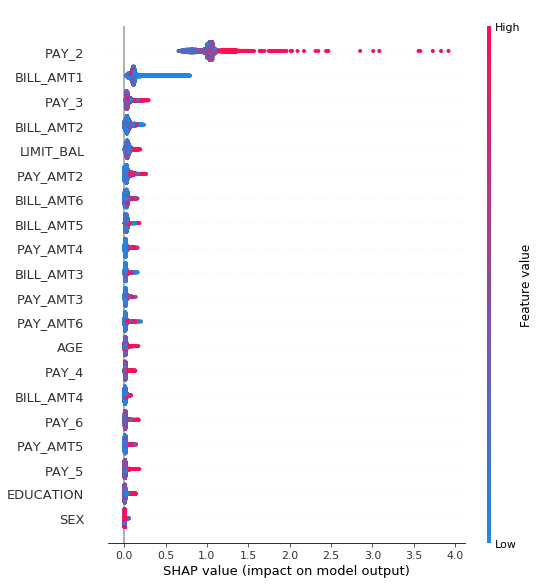

In [112]:
#Get mean absolute shapley across all classes for global shapley variable importance
shap_values_abs = np.absolute(shap_values[:,:,:-1])
#Plot global shapley variable importance
shap.summary_plot(shap_values_abs.mean(axis=1), test[xgb_model.feature_names])

### Display Shapley variable importance summary per predicted class
The global variable importance ranking should be parsimonious with human domain knowledge and reasonable expectations. In this case, `PAY_2` is by far the most important variable per class. As someone's most recent behavior is a very good indicator of future behavior, this checks out, again. 

Shapley plot for class 0


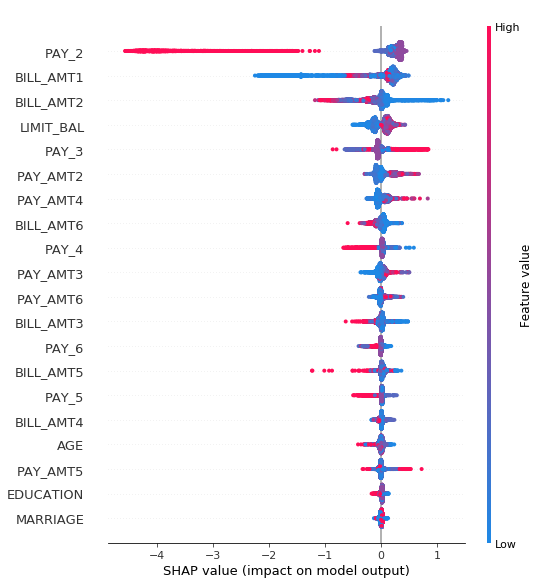

Shapley plot for class 1


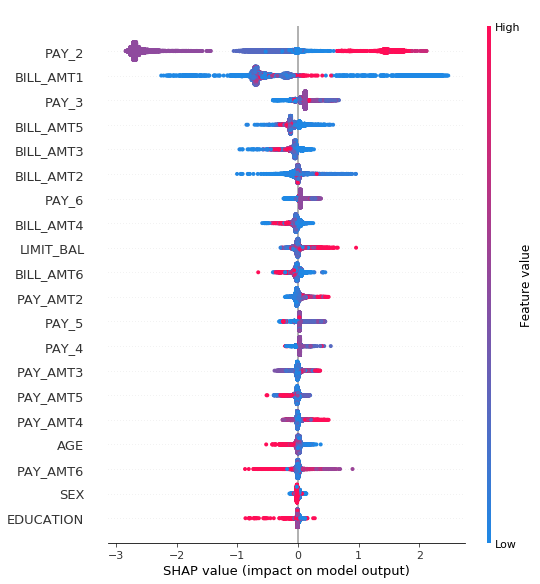

Shapley plot for class 2


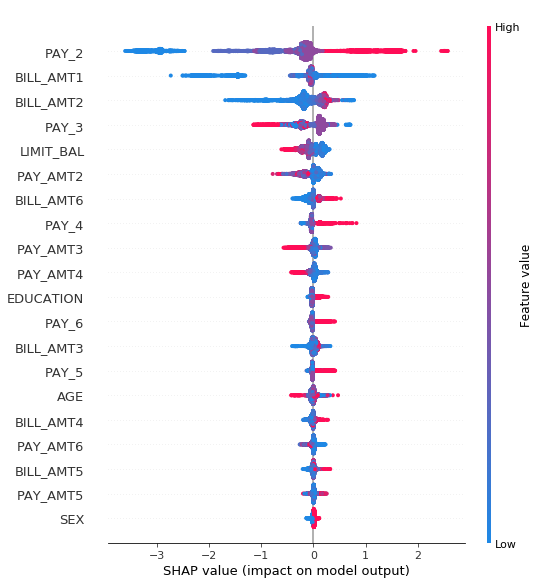

Shapley plot for class 3


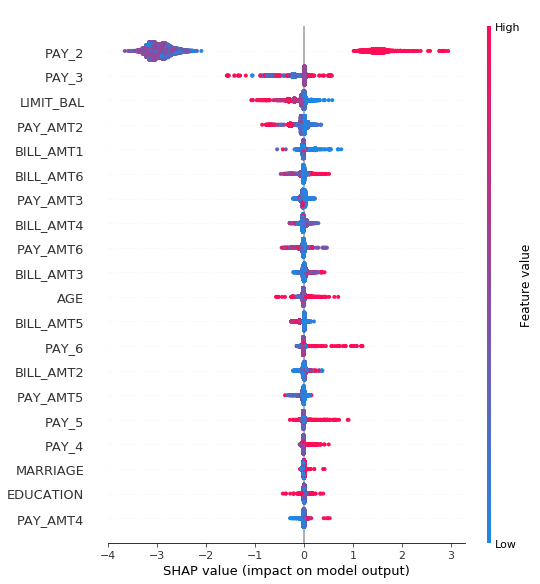

Shapley plot for class 4


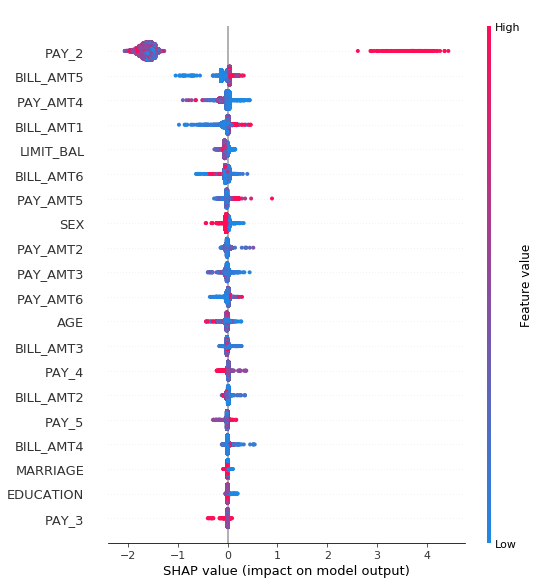

Shapley plot for class 5


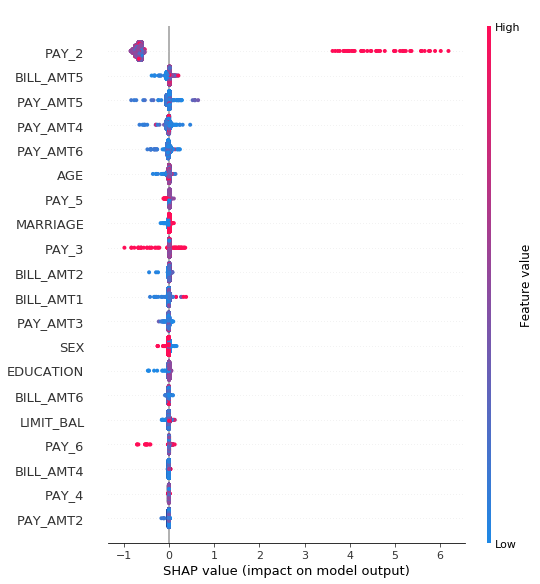

Shapley plot for class 6


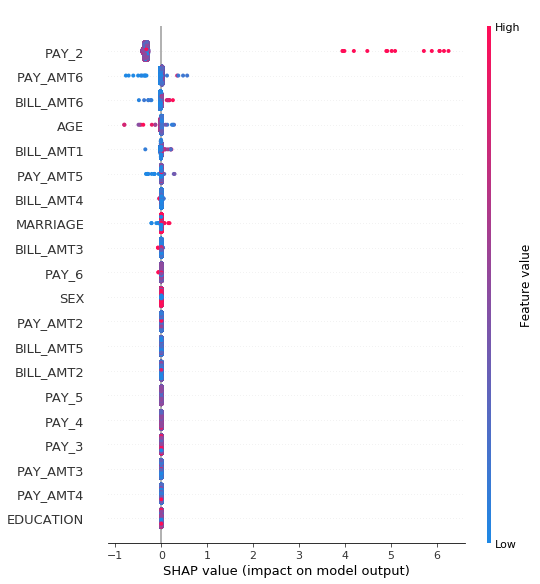

Shapley plot for class 7


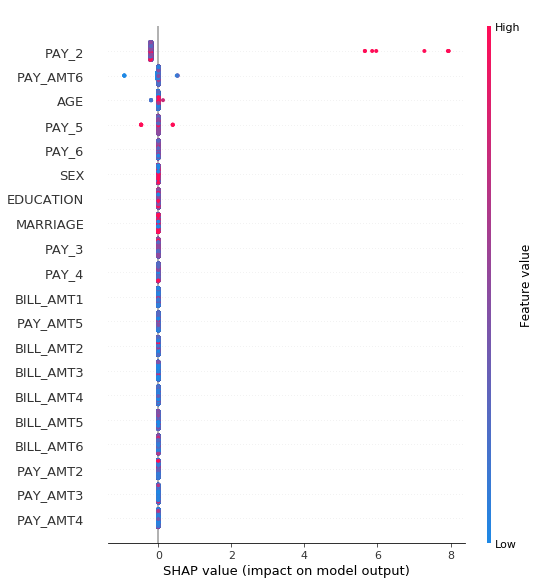

Shapley plot for class 8


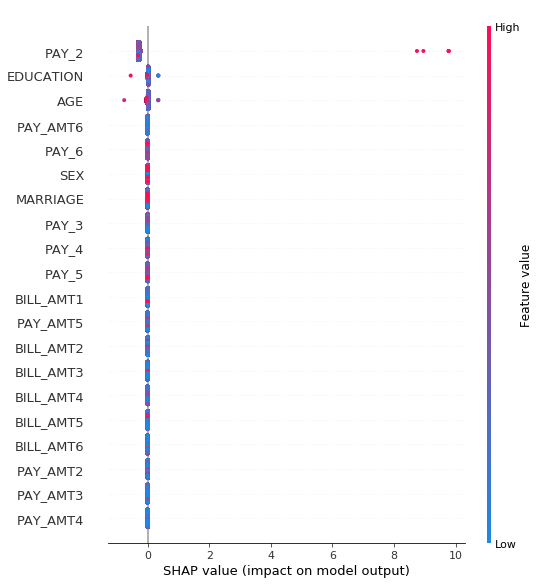

In [113]:
#Plot Shapley variable importance summary for a specific class (class 0, class 1, ..., class 8)
#PAY_0 summary:
#0:'no consumption', 'pay duly', 'use of revolving credit', 
#1:'1 month delay', 
#2:'2 month delay', 
#3:'3 month delay', 
#4:'4 month delay', 
#5:'5 month delay', 
#6:'6 month delay', 
#7:'7 month delay', 
#8:'8 month delay'
for i in range(0,9):
    print("Shapley plot for class " + str(i))
    shap.summary_plot(shap_values[:, i, :-1], test[xgb_model.feature_names])

In [114]:
#Predict on test set
preds = xgb_model.predict(dtest)

In [115]:
#Each column represents a class outcome for PAY_0: 0, 1, 2, ..., 8.
#PAY_0 summary:
#0:'no consumption', 'pay duly', 'use of revolving credit', 
#1:'1 month delay', 
#2:'2 month delay', 
#3:'3 month delay', 
#4:'4 month delay', 
#5:'5 month delay', 
#6:'6 month delay', 
#7:'7 month delay', 
#8:'8 month delay'
pd.DataFrame(preds)

,0,1,2,3,4,5,6,7,8
0,0.223108,0.620587,0.123760,0.029121,0.000686,0.000685,0.000685,0.000684,0.000684
1,0.976960,0.001886,0.020121,0.000176,0.000172,0.000171,0.000171,0.000171,0.000171
2,0.994048,0.000719,0.004626,0.000103,0.000101,0.000100,0.000100,0.000100,0.000100
3,0.991570,0.001280,0.006405,0.000127,0.000124,0.000124,0.000124,0.000124,0.000124
4,0.987425,0.009604,0.002263,0.000121,0.000118,0.000117,0.000117,0.000117,0.000117
5,0.994902,0.000728,0.003701,0.000114,0.000111,0.000111,0.000111,0.000111,0.000111
6,0.991023,0.001008,0.007366,0.000103,0.000100,0.000100,0.000100,0.000100,0.000100
7,0.403315,0.593136,0.000627,0.000499,0.000486,0.000485,0.000485,0.000484,0.000484
8,0.440191,0.556213,0.000635,0.000505,0.000492,0.000491,0.000491,0.000491,0.000491
9,0.932940,0.012091,0.053297,0.000285,0.000278,0.000277,0.000277,0.000277,0.000277


In [116]:
#Look at model accuracy
pred_prob = xgb_model.predict(dtest).reshape(test[y].shape[0], 9)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != test[y]) / test[y].shape[0]
print('Test error using softprob = {}'.format(error_rate))

Test error using softprob = 0.10989617848464767


In [117]:
#For each line we need to select that column 
#where the probability is the highest
best_preds = np.asarray([np.argmax(line) for line in preds])
best_preds

array([1, 0, 0, ..., 0, 3, 0])

In [118]:
#Get actual values of PAY_0 in test set
test_true = test["PAY_0"].values

In [119]:
#Look at confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_true, best_preds)
cnf_matrix

array([[6737,  157,    8,    0,    0,    0,    0,    0,    0],
       [  91,  902,  177,    1,    2,    2,    0,    1,    1],
       [ 307,  126,  389,    6,    2,    2,    0,    0,    0],
       [   6,   40,   34,   21,    2,    0,    0,    0,    0],
       [   0,   18,    3,    0,    0,    0,    0,    0,    0],
       [   1,    3,    0,    0,    1,    4,    0,    0,    0],
       [   0,    2,    0,    0,    2,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    2,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    4]])

In [120]:
#Look at precision and F1 with micro and macro averaging
from sklearn.metrics import precision_score, f1_score

print("Macro Precision: %s" % str(precision_score(test_true, best_preds, average='macro')))
print("Micro Precision: %s" % str(precision_score(test_true, best_preds, average='micro')))

print("Macro F1: %s" % str(f1_score(test_true, best_preds, average='macro')))
print("Micro F1: %s" % str(f1_score(test_true, best_preds, average='micro')))

Macro Precision: 0.5577086092484216
Micro Precision: 0.8901038215153523
Macro F1: 0.5247303498561733
Micro F1: 0.8901038215153523


/Users/navdeepgill/Desktop/h2oai/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/navdeepgill/Desktop/h2oai/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Calculating partial dependence for a multinomial model
Partial dependence plots are used to view the global, average prediction behavior of a variable under the multinomial model. Multinomial partial dependence plots show the average prediction per class of the multinomial model as a function of specific values of an input variable of interest, indicating how the GBM predictions per class outcome change based on the values of the input variable of interest, while taking nonlinearity into consideration and averaging out the effects of all other input variables. Partial dependence plots enable increased transparency into the GBM's mechanisms and enable validation and debugging of the GBM by comparing a variable's average predictions per class across its domain to known standards and reasonable expectations. Partial dependence plots are described in greater detail in The Elements of Statistical Learning, section 10.13: https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf.

### Function for calculating multinomial partial dependence

In [121]:
def par_dep_multinomial(xs, frame, model, resolution=20, bins=None, num_classes=0):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
        num_classes: Number of classes in outcome
    
    Returns:
        Pandas DataFrame containing partial dependence values per class.
        
    """
    
    #Turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    #Initialize empty Pandas DataFrame with correct column names
    class_name_columns = [0] * (num_classes + 1)
    class_name_columns[0] = xs
    for i in range(1, 10):
        class_name_columns[i] = 'partial_dependence_' + str(i-1)
    par_dep_frame = pd.DataFrame(columns=class_name_columns)
    
    #Cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    #Determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    #Calculate partial dependence  
    #by setting column of interest to constant 
    #and scoring the altered data and taking the mean of the predictions per class
    row_idx = 0 #Keep track of row index for proper assignment 
    #Per bin
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        #Per class
        for i in range(0, num_classes):
            par_dep_frame.loc[row_idx, xs] = j
            par_dep_j = par_dep_i[i].mean()
            par_dep_frame.loc[row_idx, 'partial_dependence_' + str(i)] = par_dep_j
        row_idx+=1 #Increment and go onto next row
        
    #Return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

### Calculate partial dependence for the most important input variable(s) in the GBM
The highest correlated variable with outcome is PAY_2 and it is also the most important variable according to global Shapley variable importance.

In [122]:
pdp_PAY_2 = par_dep_multinomial(xs="PAY_2", frame=test[X], model=xgb_model, resolution=20, bins=None, num_classes=9)
pdp_PAY_2

,PAY_2,partial_dependence_0,partial_dependence_1,partial_dependence_2,partial_dependence_3,partial_dependence_4,partial_dependence_5,partial_dependence_6,partial_dependence_7,partial_dependence_8
0,-2,0.906479,0.0895752,0.00241108,0.000261992,0.000255038,0.000254558,0.000254427,0.000254398,0.000254393
1,-1.5,0.893175,0.0824951,0.0228696,0.000249208,0.000242593,0.000242137,0.000242012,0.000241985,0.000241979
2,-1,0.893175,0.0824951,0.0228696,0.000249208,0.000242593,0.000242137,0.000242012,0.000241985,0.000241979
3,-0.5,0.908281,0.0543175,0.0358819,0.000259406,0.00025252,0.000252045,0.000251915,0.000251887,0.000251881
4,0,0.908281,0.0543175,0.0358819,0.000259406,0.00025252,0.000252045,0.000251915,0.000251887,0.000251881
5,0.5,0.182869,0.726699,0.0858455,0.000782882,0.000762101,0.000760667,0.000760275,0.00076019,0.000760173
6,1,0.182276,0.727233,0.0859007,0.00078368,0.000762878,0.000761442,0.00076105,0.000760965,0.000760948
7,1.5,0.168291,0.488496,0.299943,0.0405186,0.000551284,0.000550246,0.000549963,0.000549901,0.000549889
8,2,0.168291,0.488496,0.299943,0.0405186,0.000551284,0.000550246,0.000549963,0.000549901,0.000549889
9,2.5,0.180038,0.443474,0.225928,0.0553163,0.093231,0.000503356,0.000503097,0.00050304,0.000503029


# Plotting multinomial partial dependence
Plotting the partial dependence per class is a good way of getting a global view of the multinomial model in question. Note, if number of outcome classes > 10, we would only take the top 10 most common classes by default.

In [123]:
#PAY_0 summary:
#0:'no consumption', 'pay duly', 'use of revolving credit', 
#1:'1 month delay', 
#2:'2 month delay', 
#3:'3 month delay', 
#4:'4 month delay', 
#5:'5 month delay', 
#6:'6 month delay', 
#7:'7 month delay', 
#8:'8 month delay'
def plot_multinomial_pdp(pdp_data, xs):
    fig, ax = plt.subplots()
    for i in range(0, 9):
        pdp_PAY_2.plot(x=xs,y="partial_dependence_"+str(i), ax=ax)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

### PDP for PAY_2 across all class outcomes for `PAY_0`

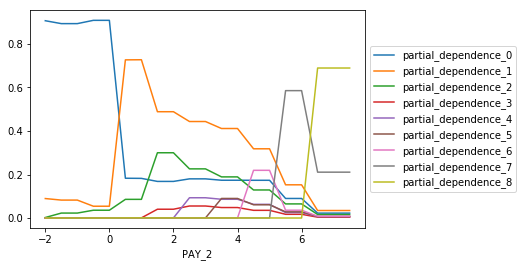

In [124]:
#PAY_0 summary:
#0:'no consumption', 'pay duly', 'use of revolving credit', 
#1:'1 month delay', 
#2:'2 month delay', 
#3:'3 month delay', 
#4:'4 month delay', 
#5:'5 month delay', 
#6:'6 month delay', 
#7:'7 month delay', 
#8:'8 month delay'
plot_multinomial_pdp(pdp_PAY_2, "PAY_2")

### Plotting partial dependence for a specific class outcome of interest

In [125]:
def plot_pdp_class_outcome(pdp_data, xs, class_category):
    fig, ax = plt.subplots()
    pdp_PAY_2.plot(x=xs,y="partial_dependence_"+str(class_category), ax=ax)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

### PDP for `PAY_2` and `PAY_0` outcome, `0` (`'no consumption', 'pay duly', 'use of revolving credit'`)

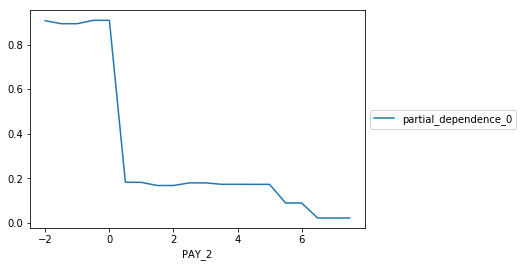

In [126]:
#PAY_0 summary:
#0:'no consumption', 'pay duly', 'use of revolving credit', 
#1:'1 month delay', 
#2:'2 month delay', 
#3:'3 month delay', 
#4:'4 month delay', 
#5:'5 month delay', 
#6:'6 month delay', 
#7:'7 month delay', 
#8:'8 month delay'
plot_pdp_class_outcome(pdp_PAY_2, "PAY_2", 0)

# Calculating Individual Conditional Expectation (ICE) for a multinomial model
Individual conditional expectation (ICE) plots, a newer and less well-known adaptation of partial dependence plots, can be used to create more localized explanations for a single observation of data using the same basic ideas as partial dependence plots. ICE is also a type of nonlinear sensitivity analysis in which the model predictions for a single observation are measured while a feature of interest is varied over its domain. ICE increases understanding and transparency by displaying the nonlinear behavior of the GBM. ICE also enhances trust, accountability, and fairness by enabling comparisons of nonlinear behavior to human domain knowledge and reasonable expectations. ICE, as a type of sensitivity analysis, can also engender trust when model behavior on simulated or extreme data points is acceptable. A detailed description of ICE is available in this arXiv preprint: https://arxiv.org/abs/1309.6392.

### Helper function for finding percentiles of predictions
ICE can be calculated for any row in the training or test data, but without intimate knowledge of a data source it can be difficult to know where to apply ICE. Calculating and analyzing ICE curves for every row of training and test data set can be overwhelming, even for the example credit card default dataset. One place to start with ICE is to calculate ICE curves at every decile of predicted probabilities in a dataset, giving an indication of local prediction behavior across the dataset. The function below finds and returns the row indices for the maximum, minimum, and deciles of one column in terms of another -- in this case, the model predictions for being in class 0 (`'no consumption', 'pay duly', 'use of revolving credit'`) and the row identifier (ID), respectively.

In [127]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

### Find some percentiles of yhat for a particular `PAY_0` outcome in the test data
The values for ID that correspond to the maximum, minimum, and deciles of being in class 0 (`'no consumption', 'pay duly', 'use of revolving credit'`) are displayed below. ICE will be calculated for the rows of the test dataset associated with these ID values.

In [128]:
def get_preds_for_class(dtest, class_category):
    #Merge GBM predictions onto test data
    yhat_test = pd.concat([test.reset_index(drop=True), pd.DataFrame(xgb_model.predict(dtest)[:,class_category])], 
                          axis=1)
    yhat_test = yhat_test.rename(columns={0:'p_class_' + str(class_category)})

    #Find percentiles of predictions
    percentile_dict = get_percentile_dict('p_class_' + str(class_category), 'ID', yhat_test)

    #Display percentiles dictionary
    #ID values for rows
    #from lowest prediction 
    #to highest prediction
    return percentile_dict

In [129]:
percentile_dict = get_preds_for_class(dtest, 0)
percentile_dict

{0: 18868,
 99: 6337,
 10: 19588,
 20: 15469,
 30: 20234,
 40: 29946,
 50: 20097,
 60: 24833,
 70: 8646,
 80: 25579,
 90: 8271}

### Calculate ICE curve values for PAY_2 against a particular `PAY_0` outcome in the test data

In [130]:
def calc_ice_curves(pdp_data, xs, id_col, class_category, num_classes):
    #Retreive bins from original partial dependence calculation
    bins = list(pdp_data[xs])
    pdp_ice_data = pdp_data[[xs, "partial_dependence_" + str(class_category)]]
    # for each percentile in percentile_dict
    # create a new column in the par_dep frame 
    # representing the ICE curve for that percentile
    # and the variables of interest
    for i in sorted(percentile_dict.keys()):

        col_name = 'Percentile_' + str(i)

        # ICE curves for PAY_0 across percentiles at bins_PAY_0 intervals
        pdp_ice_data[col_name] = par_dep_multinomial(xs, 
                                                  test[test[id_col] == int(percentile_dict[i])][X],  
                                                  xgb_model, 
                                                  bins=bins,
                                                  num_classes=num_classes)['partial_dependence_'+str(class_category)]
    return pdp_ice_data

### Calculate ICE curve values for `PAY_2` against `PAY_0` outcome, `0` (`'no consumption', 'pay duly', 'use of revolving credit'`)

In [131]:
pdp_PAY_2_class_zero = calc_ice_curves(pdp_PAY_2, "PAY_2", "ID", 0, 9)
pdp_PAY_2_class_zero

,PAY_2,partial_dependence_0,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-2,0.906479,0.827292,0.956465,0.424373,0.971166,0.9411,0.976131,0.980072,0.978572,0.943308,0.986423,0.982365
1,-1.5,0.893175,0.764713,0.946932,0.411297,0.936514,0.929537,0.95942,0.97849,0.972725,0.981343,0.98797,0.992295
2,-1,0.893175,0.764713,0.946932,0.411297,0.936514,0.929537,0.95942,0.97849,0.972725,0.981343,0.98797,0.992295
3,-0.5,0.908281,0.940785,0.992339,0.478521,0.904275,0.930825,0.94817,0.963661,0.973388,0.980687,0.988919,0.997065
4,0,0.908281,0.940785,0.992339,0.478521,0.904275,0.930825,0.94817,0.963661,0.973388,0.980687,0.988919,0.997065
5,0.5,0.182869,0.0122209,0.0432379,0.0436101,0.00764484,0.00780141,0.0131865,0.0161349,0.00660021,0.60057,0.0486532,0.115797
6,1,0.182276,0.0121733,0.0432379,0.0436101,0.00764484,0.00763233,0.0124372,0.0139298,0.00569065,0.60057,0.0486532,0.114681
7,1.5,0.168291,0.00827722,0.0235949,0.0333502,0.00717468,0.00796268,0.00753185,0.0101741,0.00611127,0.655509,0.0588886,0.104427
8,2,0.168291,0.00827722,0.0235949,0.0333502,0.00717468,0.00796268,0.00753185,0.0101741,0.00611127,0.655509,0.0588886,0.104427
9,2.5,0.180038,0.0233045,0.0192145,0.072028,0.00449594,0.0181053,0.0111674,0.0247928,0.032761,0.632807,0.0606798,0.0397545


# Plotting partial dependence and ICE for particular `PAY_0` outcome

In [132]:
def plot_par_dep_ICE(xs, par_dep_frame, class_index):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
        class_index: Class outcome of interest. XGBoost see's this as a value from 0-N where N is number of classes
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence_' + str(class_index), axis=1).plot(x=xs, 
                                                                 colormap='gnuplot',
                                                                 ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs) 
                              + ' with class ' + str(class_index) + ' as an outcome',
                       x=xs, 
                       y='partial_dependence_' + str(class_index),
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

### Plot PDP & ICE curves for `PAY_2` against being in `PAY_0` outcome, `0` ('no consumption', 'pay duly', 'use of revolving credit')

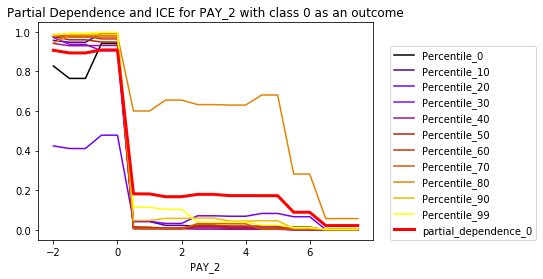

In [133]:
plot_par_dep_ICE('PAY_2', pdp_PAY_2_class_zero, 0)

# Generate reason codes using the Shapley method
Now that global behavior of the GBM has been verified and compared against domain knowledge and reasonable expectations, a method called Shapley explanations will be used to calculate the local variable importance for any one prediction: http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions. Shapley explanations are the only possible consistent local variable importance values. (Here consistency means that if a variable is more important than another variable in a given prediction, the more important variable's Shapley value will not be smaller in magnitude than the less important variable's Shapley value.) Very crucially Shapley values also always sum to the actual prediction of the XGBoost model. When used in a model-specific context for decision tree models, Shapley values are likely the most accurate known local variable importance method available today. In this notebook, XGBoost itself is used to create Shapley values with the pred_contribs parameter to predict(), but the shap package is also available for other types of models: https://github.com/slundberg/shap.

The numeric Shapley values in each column are an estimate of how much each variable contributed to each prediction. Shapley contributions can indicate how a variable and its values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are related to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders in the U.S. must provide reasons for automatically rejecting a credit application. Reason codes can be easily extracted from Shapley local variable contribution values by ranking the variables that played the largest role in any given decision.

To find the index corresponding to a particular row of interest later, the index of the test DataFrame is reset to begin at 0 and increase sequentially. Without resetting the index, the test DataFrame row indices still correspond to the original raw data from which the test set was sampled.

In [134]:
test.reset_index(drop=True, inplace=True)

### Function to plot Shapley values per class for a particular row at a certain decile

In [135]:
def plot_shapley_row(decile, row, class_index=None):
    if class_index is None:
        for i in range(0,9):
            s_df = pd.DataFrame(shap_values[row.index[0], i][:-1].reshape(21, 1), columns=['Reason Codes'], index=X)
            s_df.sort_values(by='Reason Codes', inplace=True)

            _ = s_df.plot(kind='bar', 
                              title='Reason Codes for Riskiest Customer Being in Class: ' + str(i) + '\n', 
                              legend=False)
    else:
        s_df = pd.DataFrame(shap_values[row.index[0], class_index][:-1].reshape(21, 1), columns=['Reason Codes'], index=X)
        s_df.sort_values(by='Reason Codes', inplace=True)

        _ = s_df.plot(kind='bar', 
                  title='Reason Codes for Model Prediction: ' + str(class_index) + '\n', 
                  legend=False)

### Select riskiest customer in test data
One person who might be of immediate interest is the least likely to be in categorical level `0('no consumption', 'pay duly', 'use of revolving credit')` for the target variable, `PAY_0` in the test data. This customer's row will be selected and local variable importance for the corresponding prediction will be analyzed.

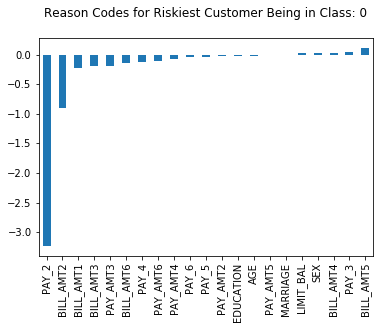

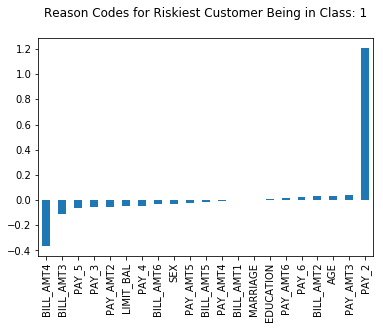

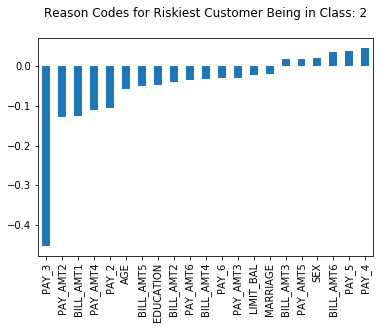

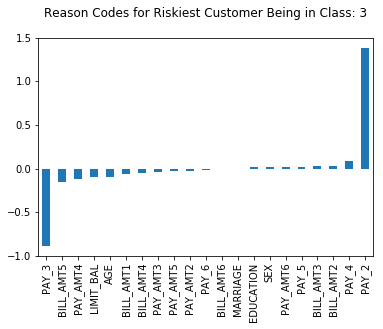

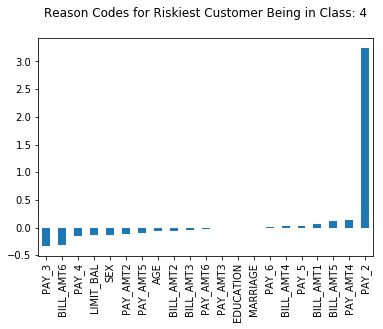

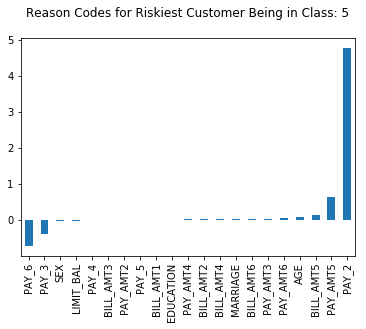

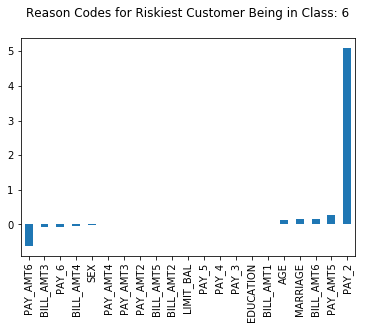

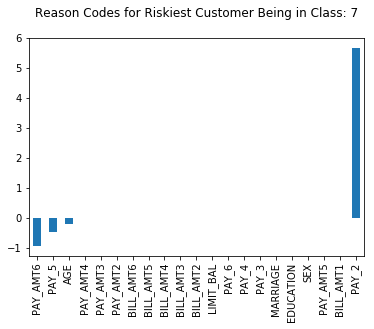

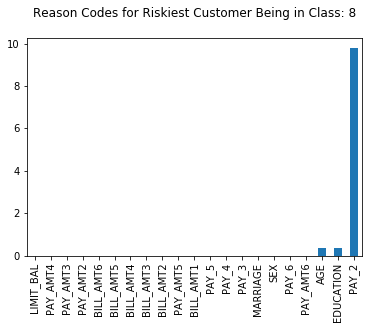

In [136]:
decile = 0
row = test[test['ID'] == percentile_dict[decile]]
plot_shapley_row(decile, row)

### Function to get model predictions for minority class and majority class based on predicted probability

In [137]:
def get_pred(row, X):
    #Double check what the model actually predicted for this row
    row_pred = xgb_model.predict(xgb.DMatrix(row[X]))
    print("Predicted class probabilies: %s" % str(row_pred[0]))
    print("Smallest class probability based on model prediction: %s" % str(np.asarray([np.argmin(line) for line in row_pred])[0]))
    print("Highest class probability based on model prediction: %s" % str(np.asarray([np.argmax(line) for line in row_pred])[0]))

### What class does the model predict the riskiest customer to be in?

In [138]:
get_pred(row, X)

Predicted class probabilies: [3.3243647e-04 7.3007452e-03 1.3987290e-03 5.3384720e-04 1.1584088e-03
 5.1838462e-03 4.7893957e-03 1.5234217e-03 9.7777915e-01]
Smallest class probability based on model prediction: 0
Highest class probability based on model prediction: 8


The above predictions are in line with what we expect for this particular row. The highest probability to miss another payment (8 months delayed) and lowest probability to fall into group zero('no consumption', 'pay duly', 'use of revolving credit'). Note the value for PAY_0, which is actually 8 and matches what the model gave the highest probability too.

### Shapley reason codes for model prediction of riskiest customer

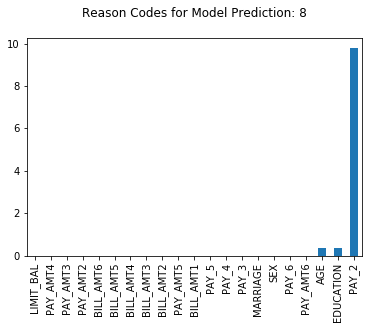

In [140]:
plot_shapley_row(0, row, 8)

### Display customer in question

In [142]:
row #Helps understand reason codes

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
5736,18868,180000,2,2,2,28,8,7,6,5,4,3,197231,194309,189981,185559,181137,184009,0,0,0,0,6000,0,1


### Select LEAST riskiest customer in test data
Another person who might be of immediate interest is the most likely to be in categorical level 0('no consumption', 'pay duly', 'use of revolving credit') for the target variable, PAY_0 in the test data. This customer's row will be selected and local variable importance for the corresponding prediction will be analyzed.

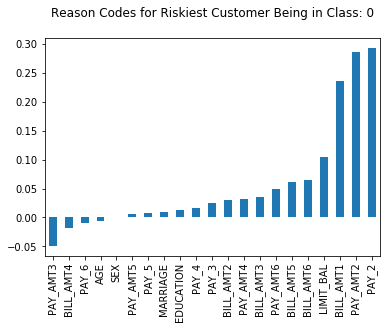

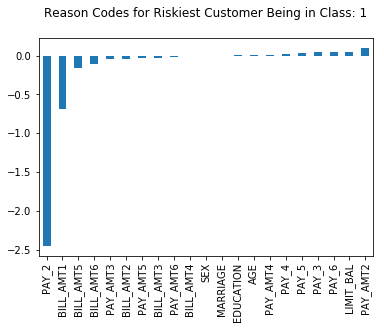

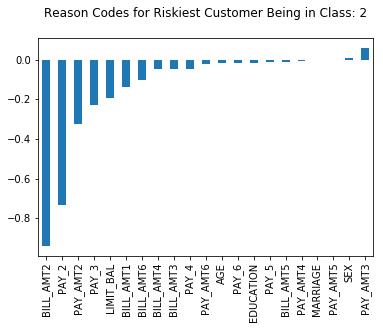

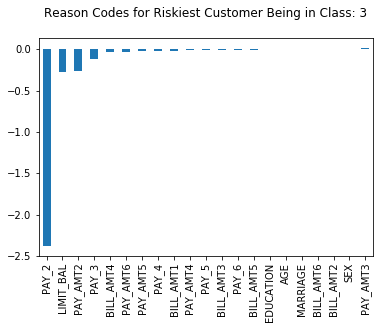

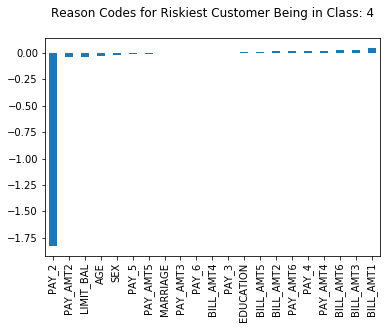

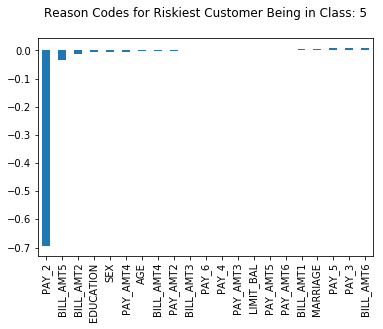

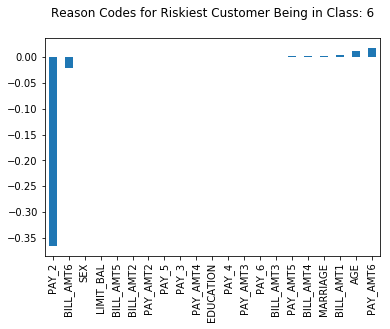

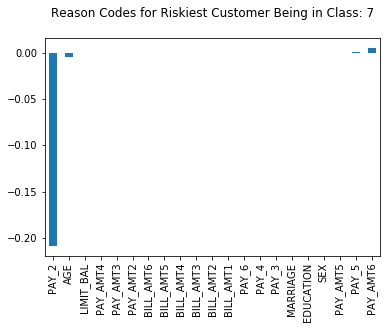

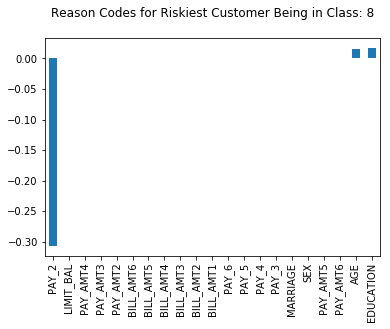

In [143]:
decile = 99
row = test[test['ID'] == percentile_dict[decile]]
plot_shapley_row(decile, row)

### What class does the model predict the LEAST riskiest customer to be in?

In [144]:
get_pred(row, X)

Predicted class probabilies: [9.97065485e-01 8.98351718e-04 1.33781973e-03 1.19200136e-04
 1.16036143e-04 1.15817675e-04 1.15758048e-04 1.15745024e-04
 1.15742485e-04]
Smallest class probability based on model prediction: 8
Highest class probability based on model prediction: 0


### Shapley Reason codes for model prediction of LEAST riskiest customer

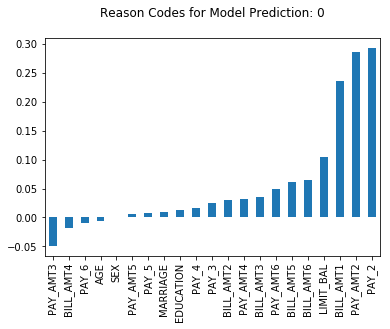

In [146]:
plot_shapley_row(decile, row, 0)

### Display customer in question

In [147]:
row #Helps understand reason codes

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1915,6337,430000,2,1,2,29,0,0,-1,0,0,0,34785,0,18518,16574,12215,6660,0,18518,5,244,1038,41500,0
